In [1]:
import sys
sys.path.append("../")

In [2]:
from mir.common.parser import *
from mir.common.repertoire import Repertoire
from mir.common.repertoire_dataset import RepertoireDataset
from mir.common.clonotype_dataset import ClonotypeDataset
from mir.basic.segment_usage import *
from mir.basic.sampling import RepertoireSampling
from pympler.asizeof import asizeof
from mir.biomarkers.fisher_biomarkers_detector import FisherBiomarkersDetector
import time

/home/evlasova/.conda/envs/bio-3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
metadata = pd.read_csv('assets/samples/fmba_healthy/desc_fmba_beta_healthy_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
metadata

,run,reads,clonotypes,folder,HLA-A.1,HLA-A.2,HLA-B.1,HLA-B.2,HLA-C.1,HLA-C.2,HLA-DPB1.1,HLA-DPB1.2,HLA-DQB1.1,HLA-DQB1.2,HLA-DRB1.1,HLA-DRB1.2,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1
0,020000330101_S185_L002.clonotypes.TRB.txt,4558846,10762,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*02:06,B*37:01,B*51:01,C*02:02,C*06:02,DPB1*03:01,DPB1*04:02,DQB1*03:01,DQB1*06:01,DRB1*08:03,DRB1*11:01,NaN,NaN,NaN
1,020003810808_S104_L002.clonotypes.TRB.txt,3117991,15211,2020/10_FMBA_NovaSeq5,A*01:02,A*31:01,B*07:02,B*15:16,C*07:02,C*14:02,DPB1*02:01,DPB1*04:01,DQB1*02:01,DQB1*06:02,DRB1*03:01,DRB1*15:01,NaN,NaN,NaN
2,020003840808_S118_L002.clonotypes.TRB.txt,1894167,8435,2020/10_FMBA_NovaSeq5,A*01:01,A*02:01,B*13:02,B*44:02,C*06:02,C*07:04,DPB1*03:01,DPB1*17:01,DQB1*02:02,DQB1*06:02,DRB1*07:01,DRB1*15:01,NaN,NaN,NaN
3,050000310808_S83_L001.clonotypes.TRB.txt,1407629,16454,2020/12_FMBA_Novaseq7_DNA,A*02:01,A*02:01,B*13:02,B*51:01,C*06:02,C*07:02,DPB1*04:01,DPB1*05:01,DQB1*02:02,DQB1*03:02,DRB1*04:03,DRB1*07:01,NaN,NaN,NaN
4,050000550101_S84_L001.clonotypes.TRB.txt,4039131,31101,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*02:01,B*50:01,B*51:01,C*03:03,C*08:03,DPB1*04:01,DPB1*05:01,DQB1*02:02,DQB1*03:03,DRB1*07:01,DRB1*09:01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,780003220808_S28_L001.clonotypes.TRB.txt,4494229,5699,2020/10_FMBA_NovaSeq4,A*01:01,A*02:01,B*38:01,B*56:01,C*01:02,C*12:03,DPB1*04:01,DPB1*04:01,DQB1*02:01,DQB1*06:03,DRB1*03:01,DRB1*13:01,NaN,NaN,NaN
79,780003440101_S87_L001.clonotypes.TRB.txt,2847425,17997,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*30:01,B*13:02,B*41:02,C*06:02,C*17:03,DPB1*02:01,DPB1*04:01,DQB1*02:02,DQB1*03:01,DRB1*07:01,DRB1*11:01,NaN,NaN,NaN
80,780003510808_S92_L001.clonotypes.TRB.txt,567555,3645,2020/10_FMBA_NovaSeq4,A*25:01,A*26:01,B*07:02,B*57:01,C*06:02,C*07:02,DPB1*04:01,DPB1*11:01,DQB1*02:02,DQB1*03:03,DRB1*07:01,DRB1*07:01,NaN,NaN,NaN
81,780003930808_S76_L001.clonotypes.TRB.txt,224067,3609,2020/10_FMBA_NovaSeq4,A*03:01,A*26:01,B*18:01,B*35:01,C*04:01,C*07:01,DPB1*04:01,DPB1*04:02,DQB1*03:01,DQB1*05:01,DRB1*01:01,DRB1*11:04,NaN,NaN,NaN


In [4]:
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=metadata,
                                 threads=32,
                                 paths=[f'assets/samples/fmba_healthy/{r["run"]}.gz' for _, r in metadata.iterrows()])
print(time.time() - t0)

loading Repertoire objects: 100%|██████████| 83/83 [00:15<00:00,  5.26it/s]


16.753268003463745


In [5]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [6]:
z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(
    repertoire_dataset=dataset, 
    gene='TRB', 
    segment_type='V', 
    group_mapping=folder_to_run_mapping, 
    metadata_column_for_group_mapping_name='run',
    standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(
    repertoire_dataset=dataset, 
    gene='TRB', 
    segment_type='J', 
    group_mapping=folder_to_run_mapping, 
    metadata_column_for_group_mapping_name='run',
    standardization_method='log_exp')

In [7]:
t0 = time.time()
dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], 
                                    threads=32)
print(time.time() - t0)

repertoire resampling in progress: 100%|██████████| 83/83 [00:33<00:00,  2.50it/s]


34.22835874557495


In [8]:
dataset

There are 83 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020000330101_S185_L002.clonotypes.TRB.txt  4558846       10762   
1  020003810808_S104_L002.clonotypes.TRB.txt  3117991       15211   
2  020003840808_S118_L002.clonotypes.TRB.txt  1894167        8435   
3   050000310808_S83_L001.clonotypes.TRB.txt  1407629       16454   
4   050000550101_S84_L001.clonotypes.TRB.txt  4039131       31101   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:06  B*37:01  B*51:01  C*02:02   
1      2020/10_FMBA_NovaSeq5  A*01:02  A*31:01  B*07:02  B*15:16  C*07:02   
2      2020/10_FMBA_NovaSeq5  A*01:01  A*02:01  B*13:02  B*44:02  C*06:02   
3  2020/12_FMBA_Novaseq7_DNA  A*02:01  A*02:01  B*13:02  B*51:01  C*06:02   
4  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:01  B*50:01  B*51:01  C*03:03   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*06:

In [9]:
dataset.clonotype_usage_matrix.clonotype_database_usage

clonotype usage matrix should be calculated. it would take a while
started public clonotypes extraction at 2024-06-18 18:07:12.911363
there are 73997 public clonotypes
finished public clonotypes extraction at 2024-06-18 18:07:15.899366
there are 73997 public clonotypes
repertoire dataset size is 470.30606842041016
all in all 83 reps, chunk size is 3, number of batches 28


clonotype usage matrix preparation: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


<83x73997 sparse matrix of type '<class 'numpy.float64'>'
	with 1507267 stored elements in Compressed Sparse Column format>

In [10]:
asizeof(dataset.clonotype_usage_matrix.clonotype_database_usage)

18384744

In [11]:
a02_pos_rd, a02_neg_rd = dataset.split_by_metadata_function(
        splitting_method=lambda x: ('A*02' in x['HLA-A.1']) | ('A*02' in x['HLA-A.2'])
    )

In [12]:
a02_pos_rd

There are 47 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020000330101_S185_L002.clonotypes.TRB.txt  4558846       10762   
1  020003840808_S118_L002.clonotypes.TRB.txt  1894167        8435   
2   050000310808_S83_L001.clonotypes.TRB.txt  1407629       16454   
3   050000550101_S84_L001.clonotypes.TRB.txt  4039131       31101   
4   050000740101_S76_L001.clonotypes.TRB.txt  4541635       20570   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:06  B*37:01  B*51:01  C*02:02   
1      2020/10_FMBA_NovaSeq5  A*01:01  A*02:01  B*13:02  B*44:02  C*06:02   
2  2020/12_FMBA_Novaseq7_DNA  A*02:01  A*02:01  B*13:02  B*51:01  C*06:02   
3  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:01  B*50:01  B*51:01  C*03:03   
4  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*03:01  B*27:05  B*35:01  C*01:02   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*06:

In [13]:
a02_neg_rd

There are 36 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020003810808_S104_L002.clonotypes.TRB.txt  3117991       15211   
1  210001740808_S153_L002.clonotypes.TRB.txt  7783196       14797   
2   210002270101_S70_L001.clonotypes.TRB.txt  4197826       29344   
3   210003070808_S84_L001.clonotypes.TRB.txt  4902255       12855   
4   270000130807_S31_L001.clonotypes.TRB.txt  7782061       22626   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0      2020/10_FMBA_NovaSeq5  A*01:02  A*31:01  B*07:02  B*15:16  C*07:02   
1      2020/10_FMBA_NovaSeq4  A*29:02  A*30:01  B*13:02  B*51:08  C*06:02   
2  2020/12_FMBA_Novaseq8_DNA  A*03:01  A*03:01  B*35:01  B*40:02  C*03:03   
3      2020/10_FMBA_NovaSeq4  A*24:02  A*26:01  B*27:14  B*35:02  C*01:02   
4      2020/10_FMBA_NovaSeq6  A*01:01  A*30:01  B*08:01  B*13:02  C*06:02   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*14:

In [14]:
fbd = FisherBiomarkersDetector(control_repertoire_dataset=a02_pos_rd,
                               ill_repertoire_dataset=a02_neg_rd, 
                               adjusted_p_value=0.05, 
                               threads=28)

created a fisher biomarker detector with 28 threads


In [15]:
t0 = time.time()
biomarkers = fbd.detect_biomarkers(adjusted_p_value=0.4)
print(time.time() - t0)

clonotype usage matrix should be calculated. it would take a while
there are 73997 public clonotypes
clonotype usage matrix should be calculated. it would take a while
there are 73997 public clonotypes
[2024-06-18 18:08:13.488415]: there are 73997 public clonotypes in ill repertoire
[2024-06-18 18:08:13.488470]: started creating func arguments
repertoire dataset size is 215.02620697021484
all in all 36 reps, chunk size is 2, number of batches 18


clonotype usage matrix preparation: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


repertoire dataset size is 264.5740203857422
all in all 47 reps, chunk size is 2, number of batches 24


clonotype usage matrix preparation: 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]


[2024-06-18 18:09:16.717680]: finished creating func arguments
[2024-06-18 18:09:16.717849]: chunksize is 73


fisher testing in progress: 100%|██████████| 73997/73997 [00:00<00:00, 74385.34it/s]


65.85041832923889


In [16]:
cd = ClonotypeDataset(clonotypes=[ClonotypeAA(cdr3aa=x) for x in biomarkers])

In [17]:
cd.clonotype_clustering

,cdr3aa,cluster
vertex ID,,
0,CASSQGEGYGYTF,0
1,CASSQGPGYGYTF,0
2,CASSQGSGYGYTF,0
3,CASSARMNTEAFF,1
4,CASSVRMNTEAFF,1
5,CASSDRMNTEAFF,1
6,CASSRGRGGTEAFF,2
7,CASSPGPNYEQYF,3
8,CASSLDLAGGSYEQYF,4


In [18]:
fbd.significant_clones

['CASSQGEGYGYTF',
 'CASSARMNTEAFF',
 'CASSRGRGGTEAFF',
 'CASSQGPGYGYTF',
 'CASSQGSGYGYTF',
 'CASSPGPNYEQYF',
 'CASSVRMNTEAFF',
 'CASSDRMNTEAFF',
 'CASSLDLAGGSYEQYF',
 'CASSQGQSNEKLFF',
 'CASSDRGPTEAFF',
 'CASSFRDRVYEQYF',
 'CASSPSRGYGYTF']

In [19]:
cd.clonotype_clustering.cluster.value_counts()

cluster
0    3
1    3
2    1
3    1
4    1
5    1
6    1
7    1
8    1
Name: count, dtype: int64

/home/evlasova/mirpy/notebooks/../mir/common/clonotype_dataset.py:167: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(plotting_df[plotting_df.cluster_size > 1], x='x', y='y', hue=color_by,
/home/evlasova/mirpy/notebooks/../mir/common/clonotype_dataset.py:170: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(plotting_df[plotting_df.cluster_size == 1], x='x', y='y', hue=color_by,


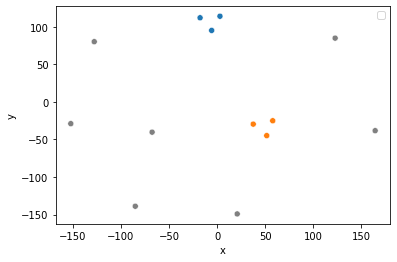

In [20]:
fig, ax = plt.subplots()
cd.plot_clonotype_clustering(color_by='cluster', ax=ax, plot_unclustered=True)
ax.legend([])

In [21]:
cd.pgens

{'CASSQGEGYGYTF': 1.2716846608827964e-07,
 'CASSARMNTEAFF': 1.568428098003348e-07,
 'CASSRGRGGTEAFF': 5.334664345362621e-08,
 'CASSQGPGYGYTF': 1.2991672591181143e-07,
 'CASSQGSGYGYTF': 9.19260538853821e-08,
 'CASSPGPNYEQYF': 9.484865104471955e-08,
 'CASSVRMNTEAFF': 1.4709938822283639e-07,
 'CASSDRMNTEAFF': 3.558441605690903e-07,
 'CASSLDLAGGSYEQYF': 1.9971784068951022e-08,
 'CASSQGQSNEKLFF': 2.9868082182972874e-08,
 'CASSDRGPTEAFF': 1.9282623311994241e-07,
 'CASSFRDRVYEQYF': 1.116442096167304e-07,
 'CASSPSRGYGYTF': 1.4109619596150275e-07}

In [22]:
cd.cluster_pgens

{0: 3.490112458854732e-07,
 1: 6.597863585922614e-07,
 2: 5.334664345362621e-08,
 3: 9.484865104471955e-08,
 4: 1.9971784068951022e-08,
 5: 2.9868082182972874e-08,
 6: 1.9282623311994241e-07,
 7: 1.116442096167304e-07,
 8: 1.4109619596150275e-07}

In [23]:
cd

A dataset of 13 clonotypes and 9 clusters

In [24]:
cd.clonotype_clustering

,cdr3aa,cluster
vertex ID,,
0,CASSQGEGYGYTF,0
1,CASSQGPGYGYTF,0
2,CASSQGSGYGYTF,0
3,CASSARMNTEAFF,1
4,CASSVRMNTEAFF,1
5,CASSDRMNTEAFF,1
6,CASSRGRGGTEAFF,2
7,CASSPGPNYEQYF,3
8,CASSLDLAGGSYEQYF,4


In [25]:
cd.serialize()